# Empirical verification of sensitivity

In [1]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

### Define ODE systems

In [14]:
def ode_system(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y 
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]



### Set up parameters, timespan, cancer latency period

In [15]:
tspan = np.linspace(0, 80, 80)
tshift = 4.79

N_crypts = 1e+7
r1 = 156
u = 10e-7 * r1
mu = 10e-9 * r1
gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
KA = 562
KR = 1780

values = {
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
    "N_crypts": N_crypts,
    "K_A": KA,
    "K_R": KR,
    "gamma_3": gamma3,
    "gamma_4": gamma4,
    "gamma_5": gamma5,
    "delta": delta,
}

### Store epidemiological data for plotting

In [16]:
# Data for Gm and Gf
Gm = [
    [57, 16.8, 6.7, 0.6],
    [62, 18.1, 8.3, 1.0],
    [67, 19.2, 9.3, 1.3],
    [72, 19.9, 10.1, 2.0],
    [77, 19.1, 10.5, 2.6],
    [58, 17.9, 7.1, 0.7],
    [63, 19.1, 8.7, 1.1],
    [68, 20.1, 9.7, 1.5],
    [73, 20.6, 10.3, 2.1],
    [78, 19.6, 10.6, 2.7]
]

Gf = [
    [57, 10.1, 3.6, 0.3],
    [62, 11.4, 4.6, 0.5],
    [67, 12.6, 5.4, 0.7],
    [72, 13.7, 6.2, 1.1],
    [77, 13.5, 6.8, 1.6],
    [58, 10.9, 3.9, 0.4],
    [63, 12.2, 4.9, 0.5],
    [68, 13.4, 5.6, 0.8],
    [73, 14.3, 6.4, 1.2],
    [78, 13.9, 7.0, 1.7]
]

# Calculate incidence per age
Gm_data = [[row[0], (row[2] + row[3]) / 100] for row in Gm]
Gf_data = [[row[0], (row[2] + row[3]) / 100] for row in Gf]

# Sort both data sets
Gm_data_sort = sorted(Gm_data, key=lambda x: x[0])
GF_data_sort = sorted(Gf_data, key=lambda x: x[0])

# Average and sort
data = [[x[0], (x[1] + y[1]) / 2] for x, y in zip(Gm_data_sort, GF_data_sort)]
data_sorted = sorted(data, key=lambda x: x[0])

# Extract x and y values for plotting
x_dat = [row[0] for row in data_sorted]
y_dat = [row[1] for row in data_sorted]

### Plot empirical verification of sensitivity for Linear ODE System

n1->n1: SSE = 0.01888161875523102
n1->n2: SSE = 0.017090980197689294
n1->n4: SSE = 4.8844207892953695e-05
n2->n2: SSE = 0.017124577113706577
n2->n3: SSE = 0.015824038045922535
n2->n5: SSE = 3.0100767571652197e-05
n3->n3: SSE = 0.5757400146187377
n3->n6: SSE = 0.01585500492332334
n4->n4: SSE = 0.042938559996916245
n4->n5: SSE = 4.850038202783826e-05
n5->n5: SSE = 0.03970821828633145
n5->n6: SSE = 0.00015537773903602034


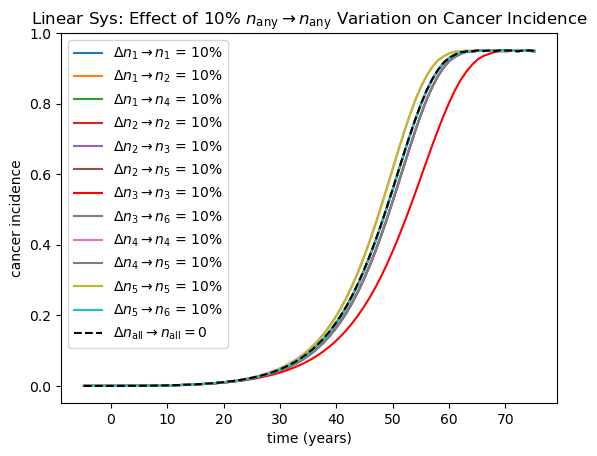

In [20]:
# NEW simulated variation in linear ode system
vary = 0.9
sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))
sol_36 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_44 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))
sol_56 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5, delta))

# Compute SSE (Sum of Squared Errors) for each case. 
SSEs = []
sol_cases = [sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_36, sol_44, sol_45, sol_55, sol_56]
case_names = ["n1->n1", "n1->n2", "n1->n4", "n2->n2", "n2->n3", "n2->n5", "n3->n3", "n3->n6", "n4->n4", "n4->n5", "n5->n5", "n5->n6"]

for sol_name, sol_case in zip(case_names, sol_cases):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"{sol_name}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol_0.t-4.79, sol_11.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol_0.t-4.79, sol_12.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol_0.t-4.79, sol_14.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol_0.t-4.79, sol_22.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol_0.t-4.79, sol_23.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol_0.t-4.79, sol_25.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_33.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_3 \rightarrow n_3$ = 10%', color='red')
plt.plot(sol_0.t-4.79, sol_36.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_3 \rightarrow n_6$ = 10%', color='gray')
plt.plot(sol_0.t-4.79, sol_44.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol_0.t-4.79, sol_45.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_55.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_56.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_5 \rightarrow n_6$ = 10%')
plt.plot(sol_0.t-4.79, sol_0.y[5,:]*(1-delta/1.01199), label=fr'$\Delta n_{{\mathrm{{all}}}} \rightarrow n_{{\mathrm{{all}}}} = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"Linear Sys: Effect of 10% $n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}}$ Variation on Cancer Incidence")
plt.savefig('LinearSensitivity.png')
plt.show()

### Plot empirical verification of sensitivity for NonLinear ODE system

n1->n1: SSE = 0.0005217545098783822
n1->n2: SSE = 0.00041146164256872274
n1->n4: SSE = 4.480590702396483e-06
n2->n2: SSE = 0.0004130148299876957
n2->n3: SSE = 1.099910161336107e-05
n2->n5: SSE = 0.00029762375394193276
n3->n3: SSE = 0.0004952627604784792
n3->n6: SSE = 5.2233994186003494e-05
n4->n4: SSE = 0.00013459157413168478
n4->n5: SSE = 0.000282308187809472
n5->n5: SSE = 0.0009026240075859004
n5->n6: SSE = 0.001170146985378255


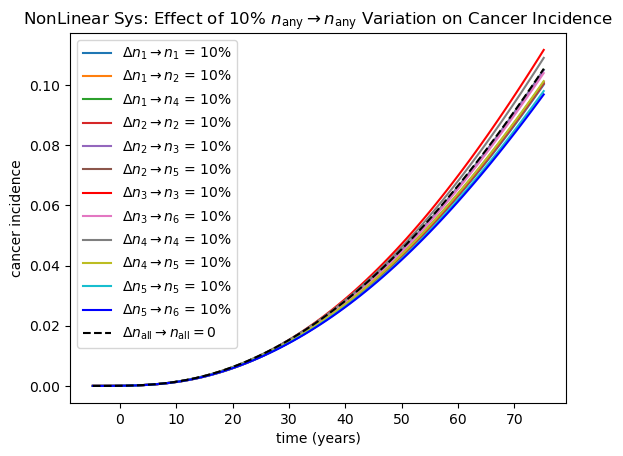

In [21]:
# NEW simulated variation in nonlinear ode system
vary = 0.9
sol_0 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))
sol_36 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_44 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))
sol_56 = solve_ivp(ode_system, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5, delta))

# Compute SSE (Sum of Squared Errors) for each case. 
SSEs = []
sol_cases = [sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_36, sol_44, sol_45, sol_55, sol_56]
case_names = ["n1->n1", "n1->n2", "n1->n4", "n2->n2", "n2->n3", "n2->n5", "n3->n3", "n3->n6", "n4->n4", "n4->n5", "n5->n5", "n5->n6"]

for sol_name, sol_case in zip(case_names, sol_cases):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"{sol_name}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol_0.t-4.79, sol_11.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol_0.t-4.79, sol_12.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol_0.t-4.79, sol_14.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol_0.t-4.79, sol_22.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol_0.t-4.79, sol_23.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol_0.t-4.79, sol_25.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_33.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_3 \rightarrow n_3$ = 10%', color='red')
plt.plot(sol_0.t-4.79, sol_36.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_3 \rightarrow n_6$ = 10%')
plt.plot(sol_0.t-4.79, sol_44.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol_0.t-4.79, sol_45.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_55.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol_0.t-4.79, sol_56.y[5, :]*(1-delta/1.01199), label=fr'$\Delta n_5 \rightarrow n_6$ = 10%', color='blue')
plt.plot(sol_0.t-4.79, sol_0.y[5,:]*(1-delta/1.01199), label=fr'$\Delta n_{{\mathrm{{all}}}} \rightarrow n_{{\mathrm{{all}}}} = 0$', linestyle='--', color='black')

# Plot observed data
#plt.scatter(x_dat, y_dat, color='black', zorder=2, label="Observed Data")

plt.xlabel('time (years)')
plt.ylabel('cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"NonLinear Sys: Effect of 10% $n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}}$ Variation on Cancer Incidence")
plt.savefig('NonLinearSensitivity.png')
plt.show()